In [20]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from random import *
class NeuralNetwork:
    """Class that creates a NN and includes methods to train and test"""
    def __init__(self, setup=[[68,25,"sigmoid"],[25,1,"sigmoid"]],lr=.05,seed=1,bias=0.5):
        #Note - these paramaters are examples, not the required init function parameters
        self._lr = lr
        self._seed = seed
        self._bias = bias
        

        # network is represented as a list of layers,
        # where layers are a list of nodes, where nodes
        # are a list of weights.
        # weights = [ [[w1,w2...], [w1,w2...]] <- layer1
        #             [[w1,w2...], [w1,w2...]] <- layer2
        #           ]
        weights = []
        outputs = []
        change = []
        
        # initialize the given number of layers with weights
        for layer in setup:
            weights.append(self.make_weights(n_inputs=layer[0],n_nodes=layer[1]))
            outputs.append([0] * layer[1])
            change.append([0] * layer[1])
        
        self._weights = weights
        self._outputs = outputs
        self._change = change
        
    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr

    @property
    def bias(self):
        return self._bias

    @bias.setter
    def bias(self, bias):
        self._bias = bias 
    
    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed 
    
    @property
    def outputs(self):
        return self._outputs

    @outputs.setter
    def outputs(self, outputs):
        self._outputs = outputs 
        
    @property
    def change(self):
        return self._change

    @change.setter
    def change(self, change):
        self._change = change 
    
    @property
    def weights(self):
        return self._weights

    @weights.setter
    def weights(self, weights):
        self._weights = weights 
        
        
    def make_weights(self,n_inputs, n_nodes):
        """
        Generates random weights for the network initialization

        Parameters
        ---------
        n_inputs
            Number of input nodes to this layer
        n_nodes
            Number of nodes to generate weights for
            
        Returns
        ---------
        Layer with random weights initialized for each node
        """
        #seed(self.seed)
        layer = []
        
        # Get n_inputs random float between -1 and 1 for each node
        for i in range(n_nodes):
            node_weights = [uniform(-1, 1) for j in range(n_inputs)]
            node_weights.append(self.bias) # add bias at end
            layer.append(node_weights)
        
        return layer

    def feedforward(self, data):
        """
        Takes in data and passes it through the NN

        Parameters
        ---------
        data
            One datapoint
            
        Returns
        ---------
        The output(s) of the final layer in the network
        """
        inputs = data
        
        # pass data through all layers
        for layer in range(len(self.weights)):
            next_inputs = []
            for node in range(len(self.weights[layer])):
                sum = 0
                for i in range(len(inputs)): # multiply inputs by weights and add to sum
                    sum += inputs[i]*self.weights[layer][node][i]
                    
                sum += self.weights[layer][node][-1] # add bias
                output = sigmoid(sum) # Apply activation function
                self.outputs[layer][node] = output
                next_inputs.append(output)
            inputs = next_inputs
        # inputs should now be the final layer output
        return inputs
    
    def backprop(self, true_values, data):
        """
        Calculates the loss and gradient for each output node.
        Propagates the gradient through the network and records
        the error for each node.
        
        Parameters
        ---------
        true_values
            true classification of example
        data
            training example

        Returns
        ---------
        None, change matrix is filled in for weight updating
        """
        # start at last layer
        for layer in reversed(range(len(self.outputs))): 
            if layer == len(self.outputs) - 1: # for last layer, calculate loss using true values
                for node in range(len(self.outputs[layer])):
                    loss = (true_values[node] - self.outputs[layer][node])
                    # fill in change matrix
                    self.change[layer][node] = loss*sigmoid_derivative(self.outputs[layer][node])
            else: # for all other layers
                for node in range(len(self.outputs[layer])):
                    loss = 0
                    # sum weighted losses from previous layer
                    for prev_layer_node in range(len(self.weights[layer + 1])):
                        loss += self.weights[layer+1][prev_layer_node][node]*self.change[layer+1][prev_layer_node]
                    # fill in change matrix
                    self.change[layer][node] = loss*sigmoid_derivative(self.outputs[layer][node])
         
        
        # Update weights
        for layer in reversed(range(len(self.outputs))): 
            input = data[0] # the input to the first layer is the training example
            if layer != 0: # the input to rest of layers is output of prev layer
                input = [self.outputs[layer-1][node] for node in range(len(self.outputs[layer - 1]))]
            for node in range(len(self.outputs[layer])):
                for i in range(len(input)):
                    self.weights[layer][node][i] += self.lr*self.change[layer][node]*input[i]
                # update bias
                self.weights[layer][node][-1] += self.lr*self.change[layer][node]


    def fit(self, training):
        """
        Trains the neural network and computes training loss.
        Performs stochastic gradient descent using backpropogation.
        
        Parameters
        ---------
        training
            A list of training examples, where each training example
            is a list where index 0 is the example, and index 1 is
            the true class.

        Returns
        ---------
        Average training loss over the training examples
        """
        train_loss = 0
        for row in training:
            output = self.feedforward(row[0])
            expected = row[-1] # Expected value should be last element of training row
            # Sum loss of all output nodes
            train_loss += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
            self.backprop(true_values=expected, data=row)
        return train_loss/len(training)
        
    def predict(self, data):
        """
        Performs one forward pass through the network to predict the 
        result
        
        Parameters
        ---------
        data
            data to be passed through

        Returns
        ---------
        Prediction from the trained network
        """
        return self.feedforward(data)
    

def sigmoid(x):
    """
    Sigmoid activation function, which scales a value
    between 0 and 1

    Parameters
    ---------
    x
        value to apply sigmoid to

    Returns
    ---------
    Transformed value
    """
    return 1/(1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    Computes the derivative of the sigmoid function

    Parameters
    ---------
    x
        value to compute the sigmoid derivative for

    Returns
    ---------
    Sigmoid derivative of the value 
    """
    return sigmoid(x)*(1 - sigmoid(x))

In [2]:
def read_train_seqs(pos_file, neg_file):
    """
    Reads in positive and negative sequences from paths
    into two lists, pos and neg. For negative sequences,
    skips the lines starting with ">"

    Parameters
    ---------
    pos_file
        path to positive examples
    neg_file
        path to negative examples
        
    Returns
    ---------
    two lists, where each element is a sequence from the file
    """
    with open(pos_file) as f:
        pos = f.read().splitlines()
    
    neg = []
    seq = ''
    for line in open(neg_file):
        if line.startswith(">"):
            if seq != '':
                neg.append(seq)
                seq = ''
        else:
            seq += line.strip() 
    neg.append(seq)
    return pos,neg

def encode_seq(sequence):
    """
    Performs one-hot encoding of a nucleotide sequence,
    where each nucleotide is represented by a binary vector
    of length 4, ie: [1, 0, 0, 0], where a 1 corresponds to
    which nucleotide it is: [A, C, G, T]

    Parameters
    ---------
    sequence
        the sequence string to encode
        
    Returns
    ---------
    A one-hot encoded sequence represented as a list of lists,
    each with length 4
    """
    encoded = []
    for nuc in sequence:
        if nuc == 'A':
            encoded+=[1,0,0,0]
        elif nuc == 'C':
            encoded+=[0,1,0,0]
        elif nuc == 'G':
            encoded+=[0,0,1,0]
        elif nuc == 'T':
            encoded+=[0,0,0,1]
    return encoded


In [12]:
def training(pos_batch_size, neg_batch_size, n_epochs, nn, pos_train, neg_train, validation):
    losses = pd.DataFrame(columns = ['Epoch', 'Train', 'Validation']) 
    
    # Add training data to queues
    pos_queue = queue.Queue(maxsize=0) 

    for i in range(len(pos_train)):
        pos_queue.put(pos_train[i])

    neg_queue = queue.Queue(maxsize=0) 

    for i in range(len(neg_train)):
        neg_queue.put(neg_train[i])

    for epoch in range(n_epochs):
        batch_losses = []
        # run through all neg examples while upsampling pos examples
        while neg_queue.empty() == False:
            # get a new batch of positive and neg examples
            neg_batch = [neg_queue.get() for i in range(neg_batch_size)]
            pos_batch = []
            for i in range(pos_batch_size):
                if pos_queue.empty(): # replenesh pos samples when necessary
                    for i in range(len(pos_train)):
                        pos_queue.put(pos_train[i])
                pos_batch.append(pos_queue.get())

            train = neg_batch + pos_batch
            shuffle(train)

            batch_losses.append(nn.fit(train))

        # Average over the batch losses    
        train_loss = sum(batch_losses)/len(batch_losses)

        val_loss = 0
        for val in validation:
            output = nn.predict(val[0])
            expected = val[-1]
            val_loss += sum([(expected[i]-output[i])**2 for i in range(len(expected))])
        losses = losses.append({'Epoch' : epoch, 'Train' : train_loss,
                                'Validation': val_loss/len(validation)}, ignore_index=True)
        if val_loss < 0.004:
            break
        # shuffle negative examples and add to queue
        shuffle(neg_train)
        for i in range(len(neg_train)):
            neg_queue.put(neg_train[i])

        shuffle(pos_train)
        pos_queue.queue.clear()
        for i in range(len(pos_train)):
            pos_queue.put(pos_train[i])

    return losses

In [ ]:

def test_make_weights():
    nn = NeuralNetwork(setup=[[8,3,"sigmoid",0],[3,8,"sigmoid",0]])
    assert len(nn.weights) == 2
    assert len(nn.weights[0]) == 3
    assert len(nn.weights[1]) == 8
    assert len(nn.weights[0][0]) == 9
    assert len(nn.weights[1][0]) == 4

def test_feedforward():
    nn = NeuralNetwork([[2,1, "sigmoid",0], [1,2, "sigmoid",0]])
    # a 2x1x2 network
    out = nn.feedforward([1,1])
    assert len(out) == 2
    assert nn.outputs[1] == out
    
def test_encoder():
    assert True

def test_encoder_relu():
    assert True

def test_one_d_ouput():
    assert True

def test_read_train_seqs():
    pos,neg = read_train_seqs(pos_file = "./data/rap1-lieb-positives.txt", neg_file = "./data/yeast-upstream-1k-negative.fa")
    print(len(pos),len(neg))
    assert len(neg) == 3164
    assert len(pos) == 137
    for i in range(len(pos)):
        assert len(pos[i]) == 17

def test_encode_seq():
    seq = 'ACTG'
    encoded = encode_seq(seq)
    assert len(encoded) == 16
    assert encoded == [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

In [ ]:
test_encode_seq()

## Test autoencoder

In [ ]:
# generate 8 bit binary vectors
identity = list(np.identity(8))

In [ ]:
train = [[list(i),list(i)] for i in identity]
train

In [ ]:
nn = NeuralNetwork([[8,3, "sigmoid"], [3,8, "sigmoid"]])

In [ ]:
losses = pd.DataFrame(columns = ['Epoch', 'Train']) 
nn.lr = 0.3
for epoch in range(2000):
    if epoch == 5000:
        nn.lr = 0.05
    loss = nn.fit(train)
    losses = losses.append({'Epoch' : epoch, 'Train' : loss}, ignore_index=True)

In [ ]:

fig,ax = plt.subplots()

for name in ['Train']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

In [ ]:
nn.predict([0,0,1,0,0,0,0,0]) 



## Part 2: Adapt for classification, and develop training regime

### 2. a) Describe your process of encoding your training DNA sequences into input vectors in detail. Include a description of how you think the representation might affect your network’s predictions.

For positive training examples, I used all 17 bp each. For the negative examples, I took the last 17 bp of each sequence. Since the neg sequences are the 1000 bp upstream of a yeast gene, I reasoned that the last 17 bp should be closest to the TSS. My hope was that these 17 bp would fall in or around an area that a transcription factor would normally bind. I'm not sure if this logic is correct, but it was a straightforward way to subset the long sequences. I think it is important for both the positive and negative examples to be potential TF binding sites so that the network learns what distinguishes a Rap1 binding site from other binding sites, rather than what distinguishes a transcription factor binding site in general. 

For the encoding, each nucleotide in a DNA sequence is represented as a binary vector of length 4. Example: [1, 0, 0, 0], where a 1 corresponds to which nucleotide it is: [A, C, G, T]. Thus, to get the entire sequence I concatenate these vectors together, resulting in a vector of length 4 * 17. Example: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]. This one-hot encoding will place equal weight on each nucleotide, rather than place more importance on some nucleotides than others. There may be some relationship between the frequency of one type of nucleotide and Rap1 binding, but I went with one-hot encoding to be safe. 

All of the positive examples were classified as 1, and neg examples classified as 0.

In [4]:
positives, full_negs = read_train_seqs(pos_file="./data/rap1-lieb-positives.txt", neg_file="./data/yeast-upstream-1k-negative.fa")

# just take the last 17 bp of all of the negatives
negatives = [seq[len(seq)-17:len(seq)] for seq in full_negs]
negatives[1:5]

['AAATCTTCACCACCCAA',
 'AGTAAATAACAGATAAT',
 'CATTGTAAAGGAAAACC',
 'AAAATAATAGGTGTAAA']

In [5]:
pos_enc = [[encode_seq(seq),[1]] for seq in positives]


In [6]:
neg_enc = [[encode_seq(seq),[0]] for seq in negatives]

### 3. a) Describe your training regime. How was your training regime designed so as to prevent the negative training data from overwhelming the positive training data?

I first split the data into 80% training, 20% validation. I tried to ensure that the validation set had a good proportion of both positives and negatives. For each epoch, I split the training data into batches, with each batch containing a balanced number of positive and negative examples. Since there are a lot more negative examples than positives, I wanted to make sure the model saw all of the negative examples while still having class-balanced batches. Thus, I re-used some of the positive examples more than once per epoch. To do this, I used two separate queues of training data--one for positive examples and one for negative examples. To create each batch, I dispense a fixed number of positives and negatives from each queue. The epoch ends when the negative queue runs out. The positive queue is replenished with examples when needed.

I also wanted to prevent the model from seeing the same ordering of examples in batches every time. To combat this I repopulated and shuffled the queues after each epoch so that the same positive and negative examples wouldn't always be in the same batch.

In [22]:
# Put some examples in a validation set. 
# 80/20 split for positives: Since there are only 137 positives, let's save 27 positives.
# Let's just save 64 negs for validation.

pos_test_len = 27
pos_test_idx = sample(range(len(pos_enc)), pos_test_len)
neg_test_len = 64
neg_test_idx = sample(range(len(neg_enc)), neg_test_len)

pos_test = [pos_enc[idx] for idx in pos_test_idx]
neg_test = [neg_enc[idx] for idx in neg_test_idx]

pos_train = [pos_enc[idx] for idx in range(len(pos_enc)) if idx not in pos_test_idx]
neg_train = [neg_enc[idx] for idx in range(len(neg_enc)) if idx not in neg_test_idx]

validation = pos_test + neg_test
shuffle(validation)

In [24]:
nn = NeuralNetwork([[68,25, "sigmoid"], [25,1, "sigmoid"]])
losses = training(pos_batch_size = 50,neg_batch_size = 155, 
                  n_epochs = 10, nn = nn, neg_train=neg_train, pos_train = pos_train, validation=validation)

### 4. a) Provide an example of the input and output for one true positive sequence and one true negative sequence.

In [25]:
# positive sequence
print("input: ", pos_enc[0][0])
print("output: ",nn.predict(pos_enc[0][0]))

input:  [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
output:  [0.9955942976671845]


In [26]:
# neg sequence
print("input: ", neg_enc[0][0])
print("output: ",nn.predict(neg_enc[0][0]))

input:  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
output:  [0.0019098420166135945]


### 4. b) Describe your network architecture, and the results of your training. How did your network perform in terms of minimizing error?

I used a network with 68 input nodes, a hidden layer with 25 nodes, and 1 output node. I used all sigmoid activations. My lr was 0.05, and I trained for 10 epochs. Both the training and validation losses steadily decrease.

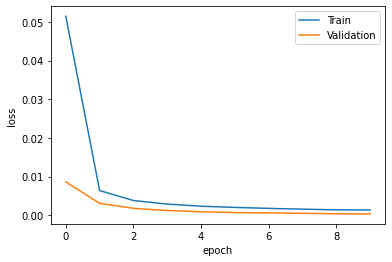

In [27]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in ['Train', 'Validation']:
    ax.plot(losses['Epoch'],losses[name], label=name)

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend(loc='best')

### 4. c) What was your stop criterion for convergence in your learned parameters? How did you decide this?

If the validation loss goes below, 0.004, the training stops. I chose 0.004 because I ran training for a range of epochs and calculated the AUC on the validation set, and it seems to reach an AUC of 0.99 at that value. If the loss was any lower, the network is not learning much more. Also, I am realizing that I did this wrong and should have probably used a held-out test set that the model has never seen to calculate the AUC.

## Part 3: Cross-validation

### 5. a) How can you use k-fold cross validation to determine your model’s performance?

K-fold cross validation ensures that the network isn't overfitting to a particular training and validation split. It splits the training data into k folds and trains k different networks where the validation set is the k-th fold, and the training set is everything minus that k-th fold. You can then average the AUCs for each fold to determine the model's performance.

### 5. b) Given the size of your dataset, positive and negative examples, how would you select a value for k?

It seems like popular values of k are 3, 5, and 10. I chose 5 so that the network can see a variety of different splits, but also so that the positive examples aren't spread too thin across the folds.

In [14]:
# Perform a 5-fold cross validation
# There are 3301 total examples, 3164 neg and 137 pos
# Need to class balance folds, so just split both pos and neg into 5 folds, then combine to form a fold
# (last fold contains the rest if uneven)
# Need to class balance the folds. 
import math

def cross_validation(k, pos_batch_size, neg_batch_size, n_epochs, pos_enc, neg_enc):
    # n examples to include in each fold
    n_pos_folds = math.floor(len(pos_enc)/k)
    n_neg_folds = math.floor(len(neg_enc)/k)

    # dict to hold validation predicted and actual classes for plotting ROC later
    all_preds = []
    all_actuals = []
    for i in range(k):
        print(i)
        if i == k-1: # for the last fold, use all remaining data
            pos_val = pos_enc[i*n_pos_folds:]
            neg_val = neg_enc[i*n_neg_folds:]
            validation = pos_val + neg_val
            shuffle(validation)
        else:
            pos_val = pos_enc[i*n_pos_folds:i*n_pos_folds+n_pos_folds]
            neg_val = neg_enc[i*n_neg_folds:i*n_neg_folds+n_neg_folds]
            validation = pos_val + neg_val
            shuffle(validation)
        # train is just all examples minus the fold
        pos_train = pos_enc[:i*n_pos_folds] + pos_enc[i*n_pos_folds+n_pos_folds:]
        neg_train = neg_enc[:i*n_neg_folds] + neg_enc[i*n_neg_folds+n_neg_folds:]

        
        nn = NeuralNetwork([[68,25, "sigmoid"], [25,1, "sigmoid"]])
        # train
        losses = training(pos_batch_size = pos_batch_size,neg_batch_size = neg_batch_size,
                          n_epochs = n_epochs, nn = nn, pos_train = pos_train, 
                          neg_train=neg_train, validation= validation)
        
        preds = []
        actuals = []
        for val in validation:
            preds.append(nn.predict(val[0])[0])
            actuals.append(val[-1][0])
        all_preds.append(preds)
        all_actuals.append(actuals)
    return all_preds, all_actuals
    

### 5. c) Using the selected value of k, determine a relevant metric of performance for each fold. Describe how your model performed under cross validation.

In [15]:
k = 5

all_preds, all_actuals = cross_validation(k = k, pos_batch_size=50, neg_batch_size = 211, n_epochs = 1, pos_enc = pos_enc, neg_enc = neg_enc)

0
1
2
3
4


In [18]:
# Get fpr, tpr, and auc for each model
result_table = pd.DataFrame(columns=['k', 'fpr','tpr','auc'])

for i in range(k):  
    fpr, tpr, _ = roc_curve(all_actuals[i],  all_preds[i])
    auc = roc_auc_score(all_actuals[i], all_preds[i])
    
    result_table = result_table.append({'k': i,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
result_table

,k,fpr,tpr,auc
0,0,"[0.0, 0.0, 0.0, 0.0015822784810126582, 0.00158...","[0.0, 0.037037037037037035, 0.1111111111111111...",0.997773
1,1,"[0.0, 0.0, 0.0, 0.1518987341772152, 0.15664556...","[0.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0...",1.000000
2,2,"[0.0, 0.0, 0.0, 0.0015822784810126582, 0.00158...","[0.0, 0.037037037037037035, 0.8888888888888888...",0.999648
3,3,"[0.0, 0.0, 0.0, 0.028481012658227847, 0.031645...","[0.0, 0.037037037037037035, 1.0, 1.0, 1.0, 1.0...",1.000000
4,4,"[0.0, 0.0, 0.0, 0.0015723270440251573, 0.00157...","[0.0, 0.034482758620689655, 0.8620689655172413...",0.999512


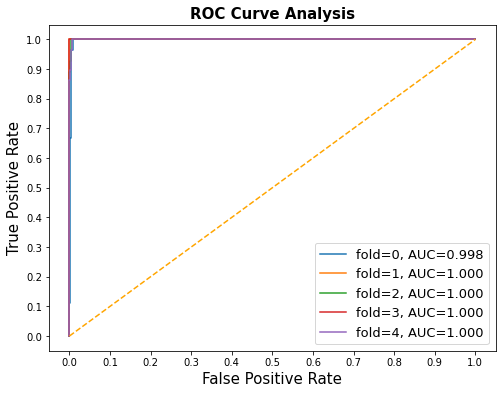

In [21]:
# ROC 
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="fold={}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Part 4: Extension

### Trying some hyperparameter optimization using grid search

In [ ]:
# try a few different architectures, lrs, and change up the positive batch size per iteration
architectures = [[[68,25, "sigmoid"], [25,10, "sigmoid"], [10,1, "sigmoid"]],
                 [[68,10, "sigmoid"], [10,5, "sigmoid"], [5,1, "sigmoid"]],
                 [[68,10, "sigmoid"], [10,1, "sigmoid"]]
                ]
lrs = [0.1, 0.05, 0.01]
pos_batch_size = [30, 50, 80]


In [ ]:
k = 5
result_table = pd.DataFrame(columns=['arch', 'lr','pos_batch_size','avg_auc'])

for arch in architectures:
    for lr in lrs:
        for pbs in pos_batch_size:
            nn = NeuralNetwork(setup = arch, lr = lr)
            all_preds, all_actuals = cross_validation(k = k, nn = nn, pos_batch_size=pbs,neg_batch_size = 211, n_epochs = 5, pos_enc = pos_enc, neg_enc = neg_enc)
            aucs = 0
            for i in range(k):  
                auc = roc_auc_score(all_actuals[i], all_preds[i])
                aucs+=auc
            avg_auc = aucs/k
            result_table = result_table.append({'arch': arch,
                                        'lr':lr, 
                                        'pos_batch_size':pbs, 
                                        'avg_auc':avg_auc}, ignore_index=True)
            print(result_table)
print(result_table)

In [ ]:
result_table

## Part 5: Evaluate your network on the final set.

In [28]:
# read in test set
with open("./data/rap1-lieb-test.txt") as f:
        test = f.read().splitlines()

In [32]:
test_enc = [encode_seq(seq) for seq in test]

In [ ]:
# make two queues
pos_queue = queue.Queue(maxsize=0) 
  
for i in range(len(pos_enc)):
    pos_queue.put(pos_enc[i])

neg_queue = queue.Queue(maxsize=0) 
  
for i in range(len(neg_enc)):
    neg_queue.put(neg_enc[i])
    
nn = NeuralNetwork([[68,25, "sigmoid"], [25,1, "sigmoid"]])
losses = training(pos_batch_size = 50,neg_batch_size = 155, n_epochs = 10, nn = nn)